# RPM Time Series Subtyping

In [1]:
# import mazebox as mb
import scvelo as scv
import scanpy as sc
import os.path as op
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import sys
import dropkick as dk
# make sure to use position 1
sys.path.insert(1, "/Users/smgroves/Documents/GitHub/Groves-CellSys2021/")
import mazebox as mb
import cellrank as cr
import scanorama

In [2]:
adata = cr.read('../../out/RPM-time-series/adata_02.h5ad')


/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `cellrank.tl.read` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  """Entry point for launching an IPython kernel.


In [3]:
X_magic = cr.read('../../out/RPM-time-series/X_magic_02.h5ad')
X_magic

/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `cellrank.tl.read` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  """Entry point for launching an IPython kernel.


AnnData object with n_obs × n_vars = 15138 × 19455
    obs: 'Diffusion Pseudotime', 'Monocle Pseudotime', 'Clusters', '_X', '_Y', 'batch', 'doublet_scores', 'predicted_doublets', 'timepoint', 'n_genes', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'barcode', 'ireland_barcode', 'M', 'E', 'clusters_gradients', 'S_score', 'G2M_score', 'phase', 'cell_cycle_diff', 'specialists_pca_diffdist'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr', 'mean', 'std', 'n_cells'
    uns: 'neighbors', 'pca', 'specialists_pca_diffdist_colors', 'timepoint_colors', 'umap'
    obsm: 'X_pca', 'X_umap', 'arc_distance', 'py_pcha_S'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [4]:
adata.layers['imputed'] = X_magic.X
adata.obsm['X_pca_imputed'] = X_magic.obsm['X_pca']

In [5]:
adata.write_h5ad('../../out/RPM-time-series/adata_03.h5ad')

# Subtyping with Archetype Signatures on Adata

In [9]:
adata = cr.read('../../out/RPM-time-series/adata_03.h5ad')

/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `cellrank.tl.read` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  """Entry point for launching an IPython kernel.


## Using Mazebox to generate archetype scores

In [10]:
sig_matrix = pd.read_csv('../../out/bulk/sig_matrix_ParTI_2021.csv', header =0, index_col = 0)

sig_matrix = sig_matrix / np.linalg.norm(sig_matrix, axis=0)
sig_matrix.index = [i.capitalize() for i in sig_matrix.index]

In [7]:
# import seaborn as sns
# max_subtype = []
# max_v = []
# sig_matrix_copy = sig_matrix.copy()
# for i,r in sig_matrix.iterrows():
#     maxi = r.idxmax()
#     maxv = r.max()
#     max_subtype.append(maxi) 
#     max_v.append(maxv)
# sig_matrix_copy['max_subtype'] = max_subtype
# sig_matrix_copy['max'] = max_v

# plt.figure(figsize=(5,30))
# sig_matrix_copy = sig_matrix_copy.sort_values(by = ['max_subtype','max'], ascending=[True, False])
# sig_matrix_copy = sig_matrix_copy[['SCLC-A','SCLC-A2','SCLC-N','SCLC-P','SCLC-Y']]
# sns.heatmap(sig_matrix_copy, cmap='viridis', yticklabels = True)
# plt.xticks(rotation = 90)
# plt.title(f'Log-transformed Archetype Expression Profiles')
# plt.tight_layout()
# # plt.savefig(op.join(outdir,f'figures/Archetypes/sig_matrix_logfc.pdf'))
# plt.show()
# plt.close()

# sig_matrix_copy.to_csv('../data/sig_matrix_ParTI.csv')

If the below code gives an error about data shape, use `type = 'csr'`.

Cells with zero expression for all genes in gene signature will get scores of NaN when assigning scores in adata.obs (because these cells are filtered for the calculation). 

Trying to set attribute `.obs` of view, copying.


Transforming tumor data...
Gene signature matrix now has shape:  (85, 5)
Tumor data shortened to genes in gene list...
(15138, 85)
Tumor data subsetting complete.


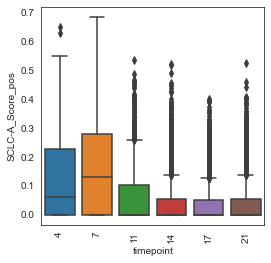

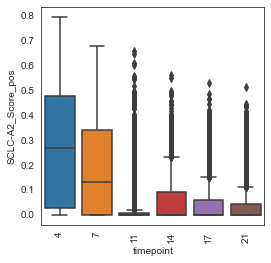

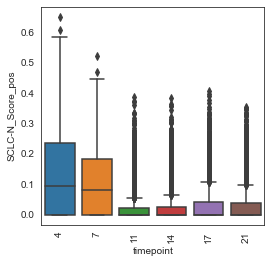

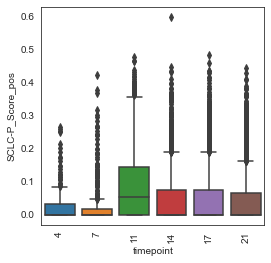

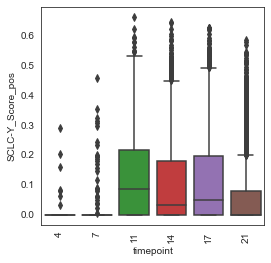

In [12]:
adata, adata_small, sig_matrix2 = mb.ar.phenotyping_recipe(adata, sig_matrix, groupby = 'timepoint',velocity=False)


In [13]:
from sklearn.manifold import LocallyLinearEmbedding
def _archetype_diagram_no_arrows(_adata, score_name, color, figsize, order, multiplier,fname,
                                 sizes = None, alpha = .3, s = 30, color_dict = None, norm = 'scale'):
    # X = subtype scores for each subtype (pd dataframe)
    n_samples = len(_adata.obs_names)

    n_types = len(sig_matrix.columns)
    subtypes = sig_matrix.columns
    X = _adata.obs[[f"{x}{score_name}" for x in subtypes]]
    top = X.sum().sort_values(ascending=False)[:3]  # return a list of n largest element
    print(top.index)

    # normalize X to sum to 1 (makes sure that the data fits within the archetype diagram with I matrix = vertices
    X_norm = pd.DataFrame(columns=X.columns)
    if norm == 'scale':
        for i, r in X.iterrows():
            if r.sum() == 0:
                X_norm = X_norm.append(r)
            else:
                X_norm = X_norm.append(r / r.sum())
    elif norm == 'max':
        max = X.max().max()
        X_norm = X / max
    elif norm == 'None':
        X_norm = X

    X = X_norm.fillna(0)
    if type(order) != type(None):
        X = X[[f"{x}{score_name}" for x in order]]
        subtypes = order
    else:
        order = subtypes

    ident = np.identity(n_types)
    for i, x in enumerate(subtypes):
        X = X.append(pd.DataFrame(np.array(ident[i]), index=X.columns, columns=[x]).T)

    embedding = LocallyLinearEmbedding(n_components=2, n_neighbors=4, method='modified', eigen_solver='dense')
    X_transformed = embedding.fit_transform(X[-n_types:])
    X_transformed = X_transformed.T

    X_df_data = embedding.transform(X[:-n_types])
    X_df_data = X_df_data.T

    fig = plt.figure(figsize=figsize)

    ax = fig.add_subplot()
    colors = _adata.obs[color].values
    if type(colors[0]) == str:
        c = [color_dict[i] for i in colors]
    else:
        c = colors
    plt.scatter(X_df_data[0], X_df_data[1], c=c, zorder=1, alpha=alpha, s=s)
    if type(sizes) == int:
        plt.scatter(X_transformed[0, -n_types:], X_transformed[1, -n_types:], c='black',
                    zorder=2, s=sizes)
    else:
        sizes = [Counter(colors)[i] * multiplier / n_samples for i in order]
        print(sizes)
        plt.scatter(X_transformed[0, -n_types:], X_transformed[1, -n_types:], c='black',
                zorder=2, s=sizes)
    plt.axis('tight')
    plt.savefig(f'./figures/{fname}.pdf')
    plt.show()
    plt.close()
    fig = plt.figure(figsize=figsize)

    ax = fig.add_subplot()
    colors = _adata.obs[color].values
    if type(colors[0]) == str:
        c = [color_dict[i] for i in colors]
    else:
        c = colors
    sns.kdeplot(X_df_data[0], X_df_data[1], cmap="Reds", shade=True, bw=.15)
    if type(sizes) == int:
        plt.scatter(X_transformed[0, -n_types:], X_transformed[1, -n_types:], c='black',
                    zorder=2, s=sizes)
    else:
        sizes = [Counter(colors)[i] * multiplier / n_samples for i in order]
        print(sizes)
        plt.scatter(X_transformed[0, -n_types:], X_transformed[1, -n_types:], c='black',
                    zorder=2, s=sizes)
    plt.axis('tight')
    plt.show()
    plt.close()


Index(['SCLC-Y_Score', 'SCLC-P_Score', 'SCLC-A_Score'], dtype='object')


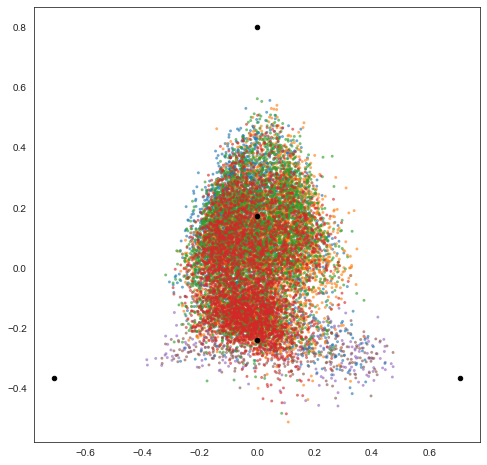

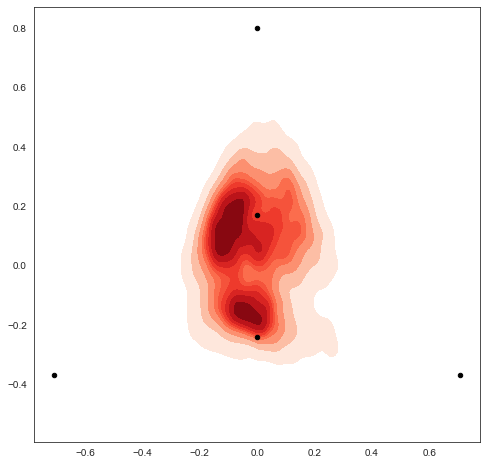

In [14]:
color_dict = {}
for i,c in enumerate(sorted(list(set(adata_small.obs['timepoint'])))):
    if i == 7:     color_dict[c] = sns.color_palette('tab10')[9] #skip grey
    else:
        color_dict[c] = sns.color_palette('tab10',8)[i]
cmap = 'jet'
_archetype_diagram_no_arrows(adata_small, color_dict=color_dict,color='timepoint',fname = 'RPM_archetype_space',
                        order = ['SCLC-Y','SCLC-A','SCLC-P','SCLC-N','SCLC-A2'], norm = 'None',
                        multiplier=1, figsize=(8,8), score_name = '_Score', alpha = .5, s = 4, sizes = 20)


## Newer phenotype classification with labeled generalists
Let's check to see how many samples have significant scores (p>.3) for more than one phenotype.

<BarContainer object of 3 artists>

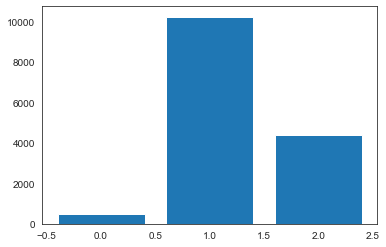

In [15]:
df = adata.obs[[f"{x}_Score_pos" for x in ['SCLC-N', 'SCLC-A', 'SCLC-P', 'SCLC-Y', 'SCLC-A2']]]
# np.unique((df > .3).sum(axis = 1), return_counts=True)[1]
plt.bar(height = np.unique(((df.T/df.sum(axis = 1)).T > .33).sum(axis = 1), return_counts=True)[1], x = range(3), log=False)

In [16]:
arc_pheno = []
arc_aa_type = []

for i,r in df.iterrows():
    r = r/r.sum()
    if (r > .33).sum() > 1:
        arc_aa_type.append('Generalist')
        arc_pheno.append(r.sort_values(ascending=False)[0:2].sort_index().index[0].split('_')[0]+"_"+r.sort_values(ascending=False)[0:2].sort_index().index[1].split('_')[0])
    elif  (r > .33).sum() == 1:
        try:
            arc_aa_type.append(r.idxmax().split('_')[0]+" Specialist")
            arc_pheno.append(r.idxmax().split('_')[0])
        except AttributeError: 
            arc_aa_type.append("Unclassified")
            arc_pheno.append("Unclassified")
    else: 
        arc_aa_type.append("Unclassified")
        arc_pheno.append("Unclassified")
adata.obs['arc_pheno'] = arc_pheno
adata.obs['arc_aa_type'] = arc_aa_type


In [18]:
pd.crosstab(adata.obs['arc_pheno'],adata.obs['timepoint']).style.background_gradient(cmap='viridis')

timepoint,4,7,11,14,17,21
arc_pheno,,,,,,
SCLC-A,32,94,237,348,371,554
SCLC-A2,99,107,208,454,301,348
SCLC-A2_SCLC-A,10,32,23,11,9,14
SCLC-A2_SCLC-N,16,31,41,130,129,245
SCLC-A2_SCLC-P,5,5,45,85,52,48
SCLC-A2_SCLC-Y,0,1,95,287,222,121
SCLC-A_SCLC-N,22,37,11,12,15,14
SCLC-A_SCLC-P,0,12,240,159,148,178
SCLC-A_SCLC-Y,0,4,237,198,216,172


In [19]:
pd.crosstab( adata.obs['arc_pheno'],adata.obs['Phenotype']).style.background_gradient(cmap='viridis')

Phenotype,Generalist,None,SCLC-A,SCLC-A2,SCLC-N,SCLC-P,SCLC-Y
arc_pheno,,,,,,,
SCLC-A,1095,521,20,0,0,0,0
SCLC-A2,1069,367,0,81,0,0,0
SCLC-A2_SCLC-A,75,24,0,0,0,0,0
SCLC-A2_SCLC-N,477,113,0,2,0,0,0
SCLC-A2_SCLC-P,165,75,0,0,0,0,0
SCLC-A2_SCLC-Y,650,76,0,0,0,0,0
SCLC-A_SCLC-N,77,34,0,0,0,0,0
SCLC-A_SCLC-P,585,152,0,0,0,0,0
SCLC-A_SCLC-Y,718,107,0,0,0,0,2


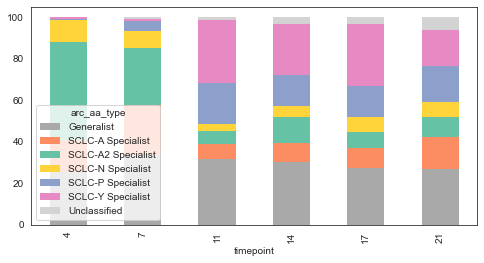

In [20]:
cp = ['#fc8d62', '#66c2a5', '#FFD43B', '#8da0cb', '#e78ac3']
color_dict = {'SCLC-Y Specialist': cp[4], 'SCLC-A Specialist': cp[0], 'SCLC-A2 Specialist': cp[1], 'SCLC-N Specialist': cp[2], 'SCLC-P Specialist': cp[3],
              'Generalist': 'darkgrey', 'Unclassified': 'lightgrey'}
mb.pl.subtype_bar(adata,groupby='timepoint', fname = 'RPM', pheno_name="arc_aa_type", custom_palette=color_dict)

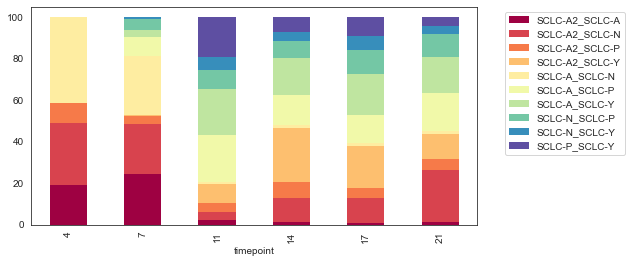

In [21]:
_adata = adata[adata.obs['arc_aa_type'] == 'Generalist']
plt.rcParams["figure.figsize"] = [8, 4]
((pd.crosstab(_adata.obs["timepoint"], _adata.obs['arc_pheno']).T /
  pd.crosstab(_adata.obs["timepoint"], _adata.obs['arc_pheno']).sum(axis=1)) * 100).T.plot(kind='bar',
                                                                                              stacked=True,
                                                                                              linewidth=0, cmap = 'Spectral')
plt.legend(bbox_to_anchor=(1.05, 1))

plt.savefig('./figures/arc_aa_generalist_subtypes.pdf')

In [21]:
# import matplotlib as mpl
# mpl.rcParams['figure.dpi']= 300
# mb.pl.archetype_diagrams(adata, sig_matrix, color_dict=color_dict, groupby='cline',color = 'arc_aa_type',
#                         order = ['SCLC-Y','SCLC-A','SCLC-P','SCLC-N','SCLC-A2'], norm = 'None',sizes = 20,
#                         figsize=(4,4), score_name = '_Score', alpha = .8, s = 8, arrows = False)


In [22]:
np.unique(adata.obs['arc_pheno'], return_counts=True)

(array(['SCLC-A', 'SCLC-A2', 'SCLC-A2_SCLC-A', 'SCLC-A2_SCLC-N',
        'SCLC-A2_SCLC-P', 'SCLC-A2_SCLC-Y', 'SCLC-A_SCLC-N',
        'SCLC-A_SCLC-P', 'SCLC-A_SCLC-Y', 'SCLC-N', 'SCLC-N_SCLC-P',
        'SCLC-N_SCLC-Y', 'SCLC-P', 'SCLC-P_SCLC-Y', 'SCLC-Y',
        'Unclassified'], dtype=object),
 array([1636, 1517,   99,  592,  240,  726,  111,  737,  827,  911,  422,
         226, 2456,  414, 3715,  509]))

In [23]:
adata.write_h5ad('../../out/RPM-time-series/adata_03.h5ad')



... storing 'Phenotype' as categorical
... storing 'arc_pheno' as categorical
... storing 'arc_aa_type' as categorical


# GMM Archetype Probabilities
CAP plots on GMM probabilities based on projection based archetype scores


In [ ]:
adata = sc.read_h5ad('../../out/RPM-time-series/adata_03.h5ad')


In [39]:
scores = adata.obs[[i for i in adata.obs.columns if '_Score_pos' in i]]


In [40]:
scores

,SCLC-A_Score_pos,SCLC-A2_Score_pos,SCLC-N_Score_pos,SCLC-P_Score_pos,SCLC-Y_Score_pos
ID,,,,,
SRR11594440:AAAGGTAGTTGCAAGGx-0-4,-0.000000,0.566151,0.085849,-0.00000,-0.000000
SRR11594440:AACCACATCCACCTCAx-0-4,-0.000000,0.546932,0.080143,-0.00000,-0.000000
SRR11594440:AAGCGAGAGACCAGACx-0-4,0.059810,0.172874,0.328460,-0.00000,-0.000000
SRR11594440:AAGTACCGTTCGTACAx-0-4,-0.000000,0.795373,0.125540,-0.00000,-0.000000
SRR11594440:AAGTCGTTCGTAGGGAx-0-4,0.054314,0.196318,0.304650,-0.00000,-0.000000
...,...,...,...,...,...
SRR11594446:TTTGGTTCAAGATTGAx-21,-0.000000,0.064044,0.104922,-0.00000,-0.000000
SRR11594446:TTTGGTTCACGAAAGCx-21,-0.000000,0.237667,0.197439,-0.00000,-0.000000
SRR11594446:TTTGTTGAGCGACTGAx-21,0.011093,0.049094,-0.000000,-0.00000,0.299872


In [91]:
# from sklearn.datasets import make_blobs
# from sklearn.mixture import GaussianMixture
# for n_samples in [50,100,500, 1000]:
#     centers = [(1, 0,0,0,0), (0,1,0,0, 0), (0,0,1,0,0), (0,0,0,1,0),(0,0,0,0,1)]
#     X, y = make_blobs(n_samples=n_samples, cluster_std = .1, centers=centers, shuffle=False, random_state=42)
#     gm = GaussianMixture(n_components=5)
#     gm.fit(pd.DataFrame(X,columns=scores.columns))
#     # scores.columns[pd.DataFrame(gm.means_).idxmax()]
#     proba = gm.predict_proba(scores)#[:,pd.DataFrame(gm.means_).idxmax()]
#     scv.pl.umap(X_magic, c = [proba[:,i] for i in range(5)], components='1,2', figsize= (5,5),ncols = 3, frameon=True, cmap = 'RdBu', smooth = True)


# ParetoTI S Matrix
1. ParetoTI: fit_pch gives an S matrix for each archetype. Take a look at these values. Maybe try a Gaussian model on these values?
2. We could also do a test where we see if each bulk archetype is enriched for S values for each archetype, and if significant, align the archetypes that way. 
3. Try doing a CAP plot for the S matrix and for the GMM-transformed S matrix


[<AxesSubplot:xlabel='UMAP1', ylabel='UMAP2'>,
 <AxesSubplot:xlabel='UMAP1', ylabel='UMAP2'>,
 <AxesSubplot:xlabel='UMAP1', ylabel='UMAP2'>,
 <AxesSubplot:xlabel='UMAP1', ylabel='UMAP2'>,
 <AxesSubplot:xlabel='UMAP1', ylabel='UMAP2'>,
 <AxesSubplot:xlabel='UMAP1', ylabel='UMAP2'>]

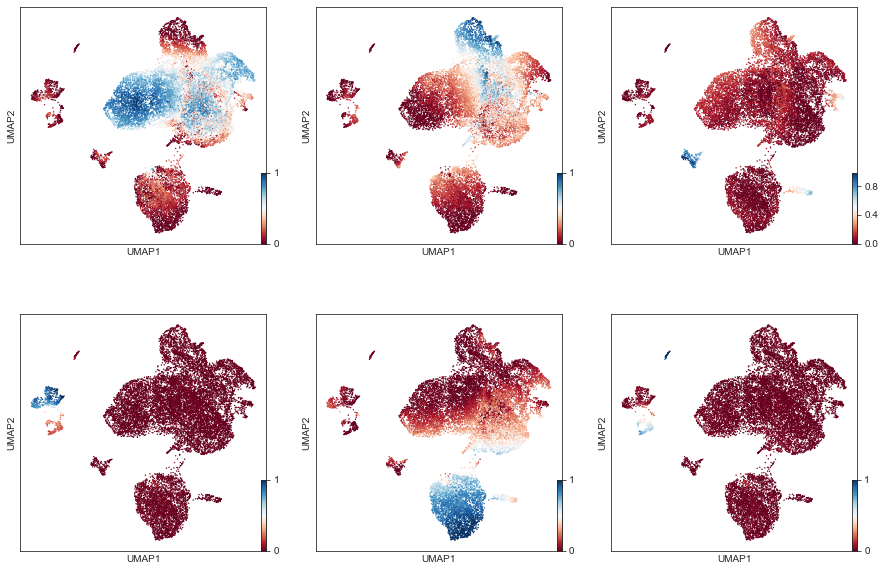

In [33]:
scv.pl.umap(X_magic, c = [X_magic.obsm['py_pcha_S'][:,i] for i in range(6)], components='1,2', show=False, figsize= (5,5),ncols = 3, frameon=True, cmap = 'RdBu')


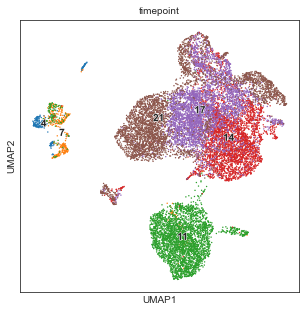

In [31]:
scv.pl.umap(X_magic, c = 'timepoint', components='1,2', figsize= (5,5), frameon=True, cmap = 'RdBu')


In [98]:
X_magic.obs = pd.merge(adata.obs.arc_aa_type,X_magic.obs, left_index=True, right_index=True)

In [109]:
X_magic.obs = pd.merge(adata.obs[[i for i in adata.obs if '_Score_pos' in i]],X_magic.obs, left_index=True, right_index=True)

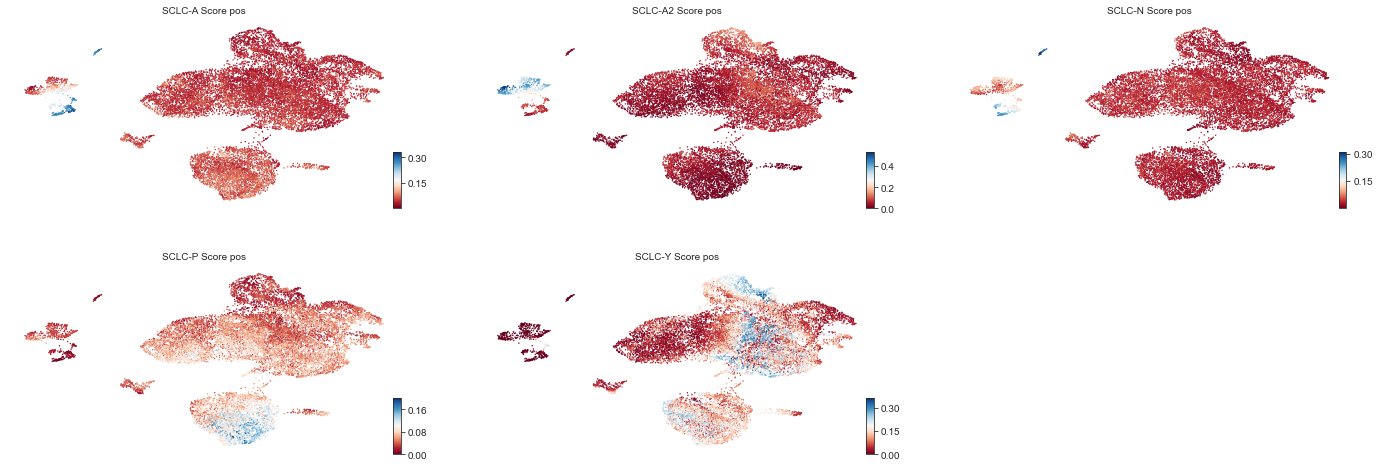

In [114]:
scv.pl.umap(X_magic, color = [i for i in adata.obs.columns if '_Score_pos' in i], legend_loc = 'on right', cmap='RdBu', ncols = 3, smooth = True)

In [115]:
X_magic

AnnData object with n_obs × n_vars = 15138 × 19455
    obs: 'SCLC-A_Score_pos', 'SCLC-A2_Score_pos', 'SCLC-N_Score_pos', 'SCLC-P_Score_pos', 'SCLC-Y_Score_pos', 'arc_aa_type', 'Diffusion Pseudotime', 'Monocle Pseudotime', 'Clusters', '_X', '_Y', 'batch', 'doublet_scores', 'predicted_doublets', 'timepoint', 'n_genes', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'barcode', 'ireland_barcode', 'M', 'E', 'clusters_gradients', 'S_score', 'G2M_score', 'phase', 'cell_cycle_diff', 'specialists_pca_diffdist'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr', 'mean', 'std', 'n_cells'
    uns: 'neighbors', 'pca', 'specialists_pca_diffdist_colors', 'timepoint_colors', 'umap', 'arc_aa_type_colors'
    obsm: 'X_pca', 'X_umap', 'arc_distance', 'py_pcha_S'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [116]:
adata

AnnData object with n_obs × n_vars = 15138 × 19455
    obs: 'Diffusion Pseudotime', 'Monocle Pseudotime', 'Clusters', '_X', '_Y', 'batch', 'doublet_scores', 'predicted_doublets', 'timepoint', 'n_genes', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'barcode', 'ireland_barcode', 'M', 'E', 'clusters_gradients', 'S_score', 'G2M_score', 'phase', 'cell_cycle_diff', 'specialists_pca_diffdist', 'SCLC-Y_Score', 'SCLC-P_Score', 'SCLC-N_Score', 'SCLC-A2_Score', 'SCLC-A_Score', 'Phenotype', 'SCLC-A_Score_pos', 'SCLC-A2_Score_pos', 'SCLC-N_Score_pos', 'SCLC-P_Score_pos', 'SCLC-Y_Score_pos', 'arc_pheno', 'arc_aa_type'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr', 'mean', 'std', 'n_cells'
    uns: 'clusters_gradients_colors', 'neighbors', 'pca', 'phase_colors', 'predicted_doublets_colors', 'timepoint_colors', 'umap'
    obsm: 'X_pca', 'X_umap', 'X_pca_imputed'
    varm: 'PCs'
    layers: 'ambiguous', 'log1p_norm_unscaled', 'matrix', 

In [117]:
adata.write_h5ad('../../out/RPM-time-series/adata_03b.h5ad')